In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
# Using pip install to install those package


In [2]:
# Interest Rate
fed_funds = pd.read_csv('./Data/US/FEDFUNDS.csv')
# Indices Data
sp500 = pd.read_csv('./Data/US/S&P 500 Historical Price Data.csv')
# Inflation Data
us_inflation = pd.read_csv('./Data/US/US Inflation Rate.csv')
# GDP Growth Rate
us_gdp = pd.read_csv('./Data/US/USGDP.csv')
# CCI Data
us_cci = pd.read_csv('./Data/US/US CCI.csv')

In [3]:
fed_funds['observation_date'] = pd.to_datetime(fed_funds['observation_date'], format='%d/%m/%Y')

us_inflation['Date'] = pd.to_datetime(us_inflation['Date'], format='%b-%y')

sp500['Date'] = pd.to_datetime(sp500['Date'])

us_gdp['Date'] = pd.to_datetime(us_gdp['Date'], format='%d/%m/%Y')

us_cci['Release Date'] = pd.to_datetime(us_cci['Release Date'], format='%d/%m/%Y')


In [4]:
# Convert all to monthly data, using the average or last value
sp500 = sp500.set_index('Date').resample('M').last()
fed_funds = fed_funds.set_index('observation_date').resample('M').last()
us_inflation = us_inflation.set_index('Date').resample('M').last()
us_gdp = us_gdp.set_index('Date').resample('M').last()
us_cci = us_cci.set_index('Release Date').resample('M').last()


In [5]:
# Merge datasets on the date index
df = pd.concat([sp500[['Price']], fed_funds['FEDFUNDS'], us_inflation['Inflation'], us_gdp['GDP growth'], us_cci['CCI Rate']], axis=1)
df.columns = ['SP500_Price', 'FEDFUNDS', 'US_Inflation', 'GDP_growth', 'CCI_Rate']

data = pd.concat([sp500[['Price']], fed_funds['FEDFUNDS'], us_inflation['Inflation'], us_gdp['GDP growth'], us_cci['CCI Rate']], axis=1)
data.columns = ['SP500_Price', 'FEDFUNDS', 'US_Inflation', 'GDP_growth', 'CCI_Rate']

df['SP500_Price'] = df['SP500_Price'].replace('[\$,]', '', regex=True)
df['SP500_Price'] = pd.to_numeric(df['SP500_Price'], errors='coerce')

data['SP500_Price'] = data['SP500_Price'].replace('[\$,]', '', regex=True)
data['SP500_Price'] = pd.to_numeric(data['SP500_Price'], errors='coerce')

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Nomarlise the data
scaler = MinMaxScaler()
df['FEDFUNDS_adj'] = scaler.fit_transform(df[['FEDFUNDS']])
df['SP500_Price_adj'] = scaler.fit_transform(df[['SP500_Price']])
df['US_Inflation_adj'] = scaler.fit_transform(df[['US_Inflation']])
df['GDP_growth_adj'] = scaler.fit_transform(df[['GDP_growth']])
df['CCI_Rate_adj'] = scaler.fit_transform(df[['CCI_Rate']])

data['FEDFUNDS_adj'] = scaler.fit_transform(data[['FEDFUNDS']])
data['SP500_Price_adj'] = scaler.fit_transform(data[['SP500_Price']])
data['US_Inflation_adj'] = scaler.fit_transform(data[['US_Inflation']])
data['GDP_growth_adj'] = scaler.fit_transform(data[['GDP_growth']])
data['CCI_Rate_adj'] = scaler.fit_transform(data[['CCI_Rate']])


df.dropna(inplace=True)

In [16]:
from sklearn.preprocessing import MinMaxScaler

# Define the range of lags for each variable
lag_ranges = {
    'FEDFUNDS': range(1, 13),
    'US_Inflation': range(-6, 13),
    'CCI_Rate': range(-6, 13),
    'GDP_Growth': range(-6, 13)
}

def fill_missing_with_sampling(df, column, lag, date_range):
    if lag < 0:
        fill_dates = pd.date_range(start=date_range[1] + pd.DateOffset(months=1), periods=-lag, freq='M')
        
        # Fetch fill values and adjust them using the same scaler
        fill_values = data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df[column].shift(lag)
        
        filled_series[lag:] = fill_values
    
    elif lag > 0:
        fill_dates = pd.date_range(end=date_range[0] - pd.DateOffset(months=1), periods=lag, freq='M')
        
                # Fetch fill values and adjust them using the same scaler
        fill_values = data.loc[fill_dates, column].values

        # Combine original and scaled fill values
        filled_series = df[column].shift(lag)
        
        filled_series[:lag] = fill_values
    else:
        return df[column]
    
    return filled_series

# Initialize variables to keep track of the best model
best_r_squared = -np.inf
best_model = None
best_lags = None

date_range = [pd.to_datetime('31/01/2015', format='%d/%m/%Y'), pd.to_datetime('31/12/2021', format='%d/%m/%Y')]

# Iterate over all combinations of lags
for f_lag in lag_ranges['FEDFUNDS']:
    for i_lag in lag_ranges['US_Inflation']:
        for c_lag in lag_ranges['CCI_Rate']:
            for g_lag in lag_ranges['GDP_Growth']:
                # Create lagged DataFrame using fill_missing_with_sampling
                df_lagged = pd.DataFrame({
                    'FEDFUNDS_lag': fill_missing_with_sampling(df, 'FEDFUNDS_adj', f_lag, date_range),
                    'US_Inflation_lag': fill_missing_with_sampling(df, 'US_Inflation_adj', i_lag, date_range),
                    'CCI_Rate_lag': fill_missing_with_sampling(df, 'CCI_Rate_adj', c_lag, date_range),
                    'GDP_Growth_lag': fill_missing_with_sampling(df, 'GDP_growth_adj', g_lag, date_range),
                    'SP500_Price_adj': df['SP500_Price_adj']
                })

                # Define predictors and response
                X = df_lagged[['FEDFUNDS_lag', 'US_Inflation_lag', 'CCI_Rate_lag', 'GDP_Growth_lag']]
                y = df_lagged['SP500_Price_adj']
                X = sm.add_constant(X)  # Adds a constant term to the predictors

                # Fit model
                model = sm.OLS(y, X).fit()

                # Check if this model is the best so far
                if model.rsquared > best_r_squared:
                    best_r_squared = model.rsquared
                    best_model = model
                    best_lags = (f_lag, i_lag, c_lag, g_lag)

# Output the best model results
print("Best R-squared:", best_r_squared)
print("Best Lags: FEDFUNDS_lag={}, US_Inflation_lag={}, CCI_Rate_lag={}, GDP_Growth_lag={}".format(*best_lags))
with open('./Results/lags/US/regression_summary_bestfit.txt', 'w') as file:
    file.write(best_model.summary().as_text())

Best R-squared: 0.936563211338363
Best Lags: FEDFUNDS_lag=12, US_Inflation_lag=-6, CCI_Rate_lag=-6, GDP_Growth_lag=8


#### Laggin Effect

#### Laggin Effect

#### Laggin Effect

#### Laggin Effect

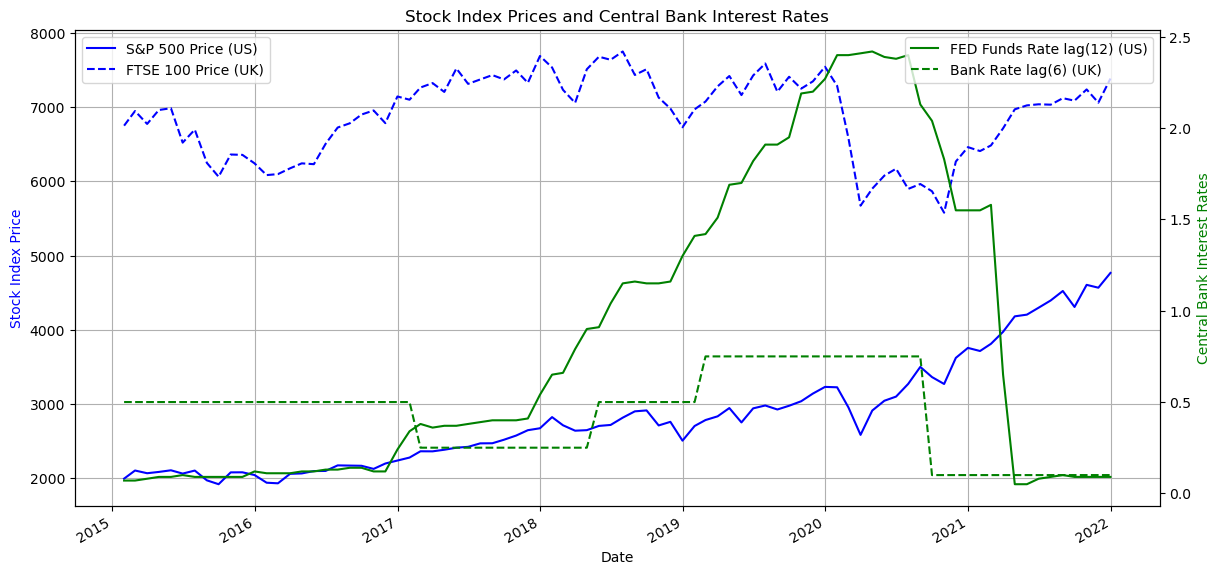

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设你已经将数据加载到了Pandas DataFrame中
# us_data 和 uk_data DataFrame结构应与之前相同

# 加载数据（这里假设你已经以某种方式加载了数据）
us_data = pd.read_csv('US_lag.csv')
uk_data = pd.read_csv('UK_lag.csv')

# 将日期列转换为日期类型
us_data['Date'] = pd.to_datetime(us_data['Date'])
uk_data['Date'] = pd.to_datetime(uk_data['Date'])

# 创建一个图表和轴对象
fig, ax1 = plt.subplots(figsize=(14, 7))

# # 绘制美国和英国的指数价格
# ax1.plot(us_data['Date'], us_data['SP500_Price'], 'b-', label='S&P 500 Price (US)')
# ax1.plot(uk_data['Date'], uk_data['FTSE100_Price'], 'b--', label='FTSE 100 Price (UK)')

# # 创建第二个y轴
# ax2 = ax1.twinx()
# # 绘制美国和英国的央行利率
# ax2.plot(us_data['Date'], us_data['FEDFUNDS'], 'g-', label='FED Funds Rate (US)')
# ax2.plot(uk_data['Date'], uk_data['Bank_Rate'], 'g--', label='BoE Interest Rate (UK)')

# # 设置图表标题和轴标签
# ax1.set_title('Stock Index Prices and Central Bank Interest Rates')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Stock Index Price', color='b')
# ax2.set_ylabel('Inflation Rate', color='g')

#####################################################

# 绘制美国和英国的指数价格
ax1.plot(us_data['Date'], us_data['SP500_Price_adj'], 'b-', label='S&P 500 Price (US)')
ax1.plot(uk_data['Date'], uk_data['FTSE100_Price_adj'], 'b--', label='FTSE 100 Price (UK)')

# 创建第二个y轴
ax2 = ax1.twinx()
# 绘制美国和英国的央行利率
ax2.plot(us_data['Date'], us_data['FEDFUNDS_lag'], 'g-', label='FED Funds Rate lag(12) (US)')
ax2.plot(uk_data['Date'], uk_data['Bank_Rate_lag'], 'g--', label='Bank Rate lag(6) (UK)')

# 设置图表标题和轴标签
ax1.set_title('Stock Index Prices and Central Bank Interest Rates')
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Index Price', color='b')
ax2.set_ylabel('Central Bank Interest Rates', color='g')

####################################################

# 设置图例，分别对应两个y轴
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid()

# 格式化x轴日期显示
fig.autofmt_xdate()
# 展示图表
plt.show()